# Problema 1

## Librerías

In [ ]:
!pip install --quiet tensorflow scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

## Carga del dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar el dataset (modifica la ruta si es necesario)
file_path = '/content/TP1-1/Student_Performance.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análisis exploratorio (EDA)

In [ ]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Observamos que no hay datos faltantes.

In [ ]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


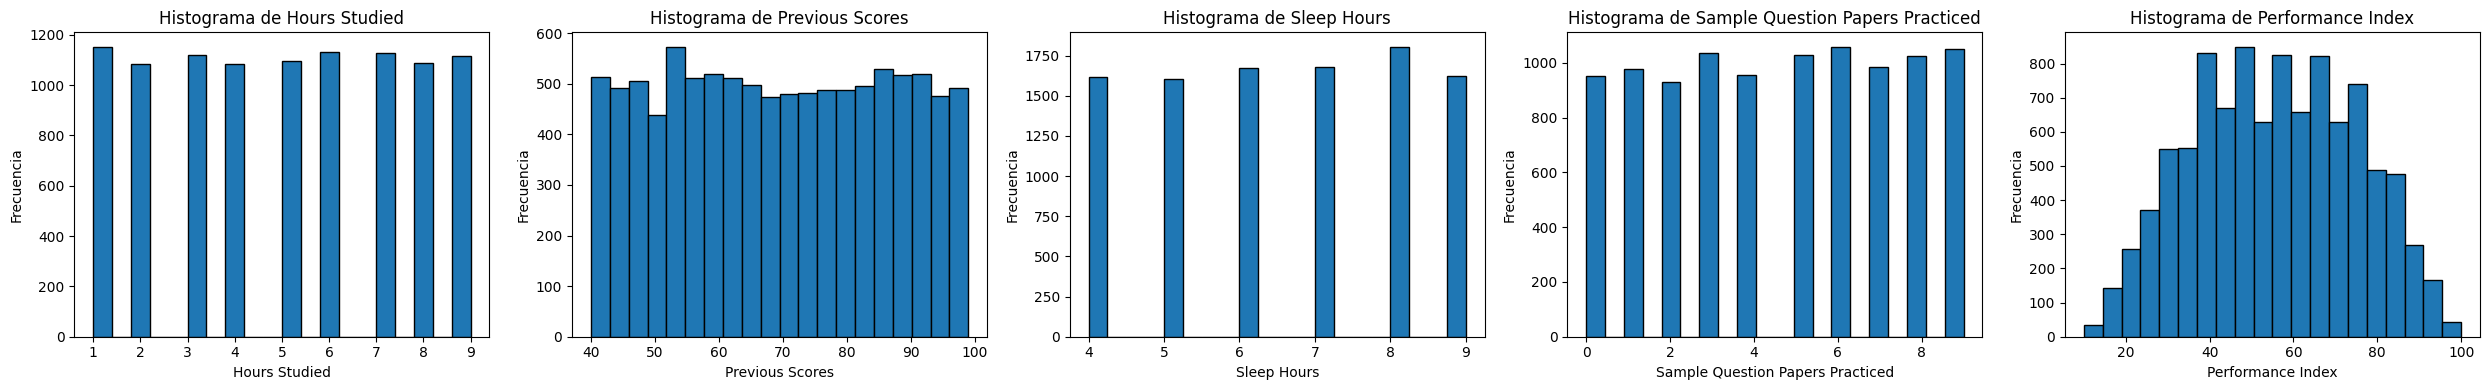

In [ ]:
numerical_vars = [
    'Hours Studied',
    'Previous Scores',
    'Sleep Hours',
    'Sample Question Papers Practiced',
    'Performance Index'
]

n = len(numerical_vars)

# Crear figura y subplots en una fila
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))  # Tamaño adaptable al número de gráficas

# Generar los histogramas en cada subplot
for i, var in enumerate(numerical_vars):
    ax = axes[i]
    ax.hist(df[var].dropna(), bins=20, edgecolor='k')
    ax.set_title(f'Histograma de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las variables independientes están perfectamente balanceadas, lo que sugiere un dataset sintético o cuidadosamente construido para entrenamiento.

El target (Performance Index) tiene una distribución realista, lo cual es positivo para evaluar generalización del modelo.

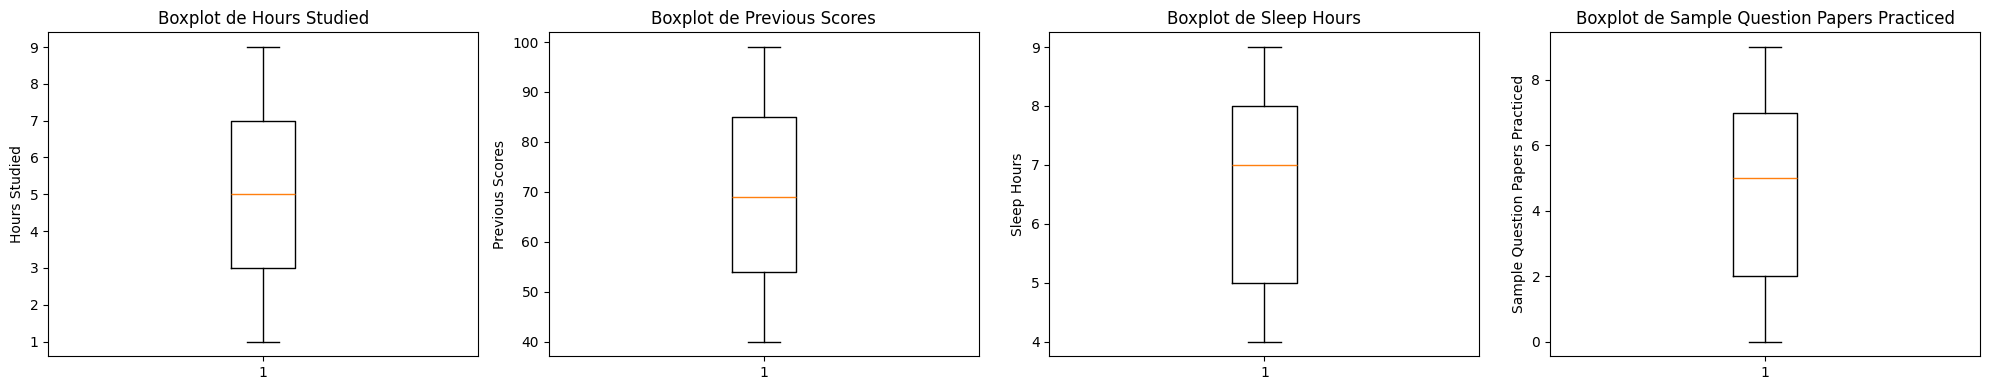

In [ ]:
# Variables numéricas a graficar (excluyendo 'Performance Index')
num_vars = numerical_vars[:-1]
n = len(num_vars)

# Crear figura y subplots en una fila
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))  # Ajusta el tamaño si lo deseas

# Generar los boxplots uno al lado del otro
for i, var in enumerate(num_vars):
    ax = axes[i]
    ax.boxplot(df[var].dropna(), vert=True)
    ax.set_title(f'Boxplot de {var}')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

Todos los boxplots confirman que las variables tienen un rango controlado, sin valores atípicos ni sesgos extremos, lo cual favorece la estabilidad del modelo y la claridad en las inferencias.

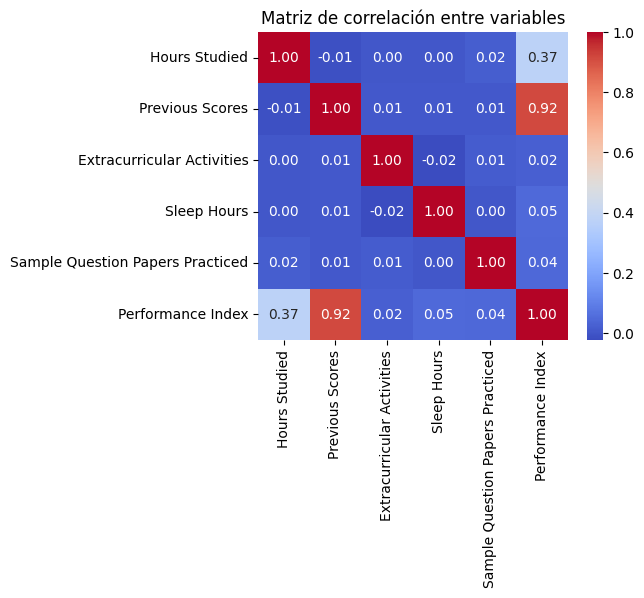

In [ ]:
# Codificar la columna categórica para incluirla en la correlación
df_corr = df.copy()
df_corr['Extracurricular Activities'] = LabelEncoder().fit_transform(df_corr['Extracurricular Activities'])

plt.figure(figsize=(5, 4))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

- Previous Scores	y Performance Index: Relación lineal muy fuerte (ρ = 0.92). Los exámenes previos son, con diferencia, el mejor predictor del rendimiento. Es llamativo como su altísima correlación sugiere que el modelo podría aprender a predecir casi únicamente a partir de esta variable, relegando al resto. No es “fuga de datos” (data leakage) —es una característica legítima—, pero conviene reportarlo porque reduce la utilidad de las demás variables.  

- Hours Studied	y Performance Index: Correlación moderada‑alta (ρ = 0.37). Más horas de estudio tienden a elevar el índice, pero con mucha mayor dispersión que Previous Scores.  
  
- El resto de las variables tienen correlación muy baja o nula con el rendimiento, indicando que no son predictoras relevantes en este caso.


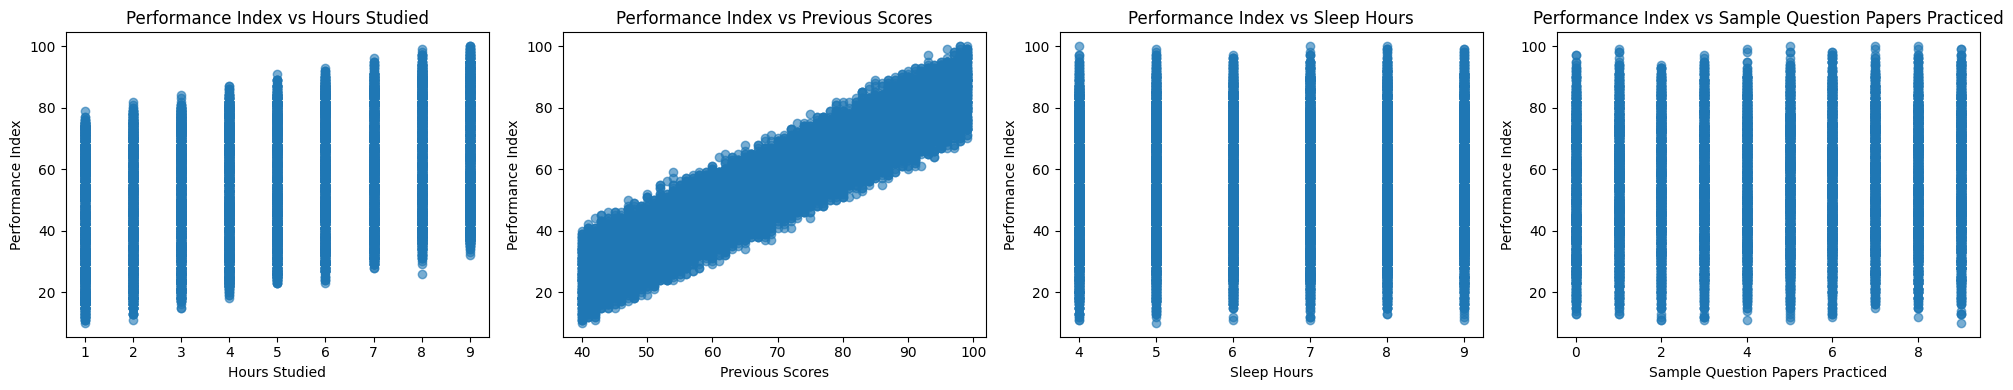

In [ ]:
# Número de variables numéricas a graficar (exceptuando 'Performance Index')
num_vars = numerical_vars[:-1]
n = len(num_vars)

# Crear figura y ejes en una fila
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))  # Ajusta el tamaño si lo deseas

# Iterar sobre las variables y graficar en cada eje correspondiente
for i, var in enumerate(num_vars):
    ax = axes[i]
    ax.scatter(df[var], df['Performance Index'], alpha=0.6)
    ax.set_title(f'Performance Index vs {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Performance Index')

plt.tight_layout()
plt.show()

Las gráficas respaldan lo observado en la matriz de correlación.

## Preprocesamiento

In [ ]:
# Codificar binaria (está bien con 0/1)
df['Extracurricular Activities'] = LabelEncoder().fit_transform(df['Extracurricular Activities'])

# Separar X e y
X = df.drop("Performance Index", axis=1)
y = df["Performance Index"]

# Partición primero, estratificando por la binaria
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=X['Extracurricular Activities'],
    random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Definición del modelo

In [ ]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entrenamiento

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3092.1458 - mae: 52.0199 - val_loss: 1083.6395 - val_mae: 29.5774
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 498.5599 - mae: 18.1172 - val_loss: 46.6265 - val_mae: 5.4502
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 44.3624 - mae: 5.2722 - val_loss: 36.4615 - val_mae: 4.8373
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 34.3760 - mae: 4.6439 - val_loss: 28.9851 - val_mae: 4.3013
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 27.9576 - mae: 4.1954 - val_loss: 23.7339 - val_mae: 3.8739
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 22.9899 - mae: 3.7956 - val_loss: 19.3812 - val_mae: 3.5040
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.7487 - mae: 3.4490 - val_loss: 16.0785 - val_mae: 3.1717
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.5370 - mae: 3.1385 - val_loss: 13.8078 - val_mae: 2.9352
Epoch 9/25
200/200 ━━━━━━━━━━━━

## Gráfica de entrenamiento

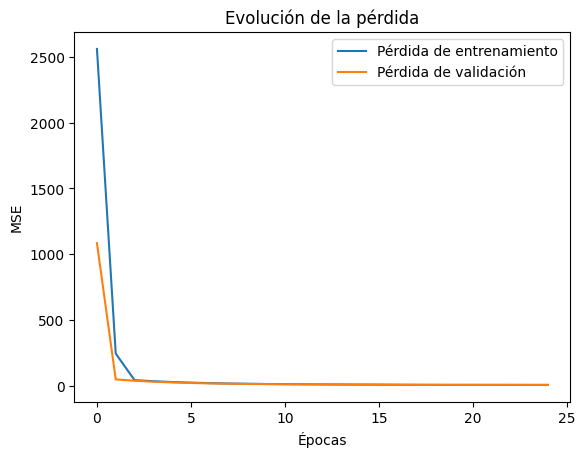

In [ ]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución de la pérdida')
plt.legend()
plt.show()

Pérdida de entrenamiento:

- Comienza muy alta (MSE > 2000) y cae bruscamente en las primeras 2–3 épocas, lo cual indica que el modelo aprendió rápidamente patrones fuertes en los datos.

- Luego se estabiliza cerca de cero, mostrando un excelente ajuste al conjunto de entrenamiento.

Pérdida de validación:

- También cae rápidamente y se mantiene muy baja y estable a lo largo de todas las épocas.

- Se mantiene casi igual a la de entrenamiento, sin aumento posterior.

En conclusión, el modelo no está memorizando los datos; generaliza bien. Casi toda la ganancia ocurre antes de la época 10. El resto del entrenamiento refina muy poco. MSE final muy bajo que confirma lo observado en las métricas (RMSE ≈ 2), lo que implica gran precisión.




## Evaluación del modelo

In [ ]:
y_pred = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 1.69
RMSE: 2.13
R² Score: 0.99


Las métricas indican que modelo es confiable, preciso y generaliza bien.

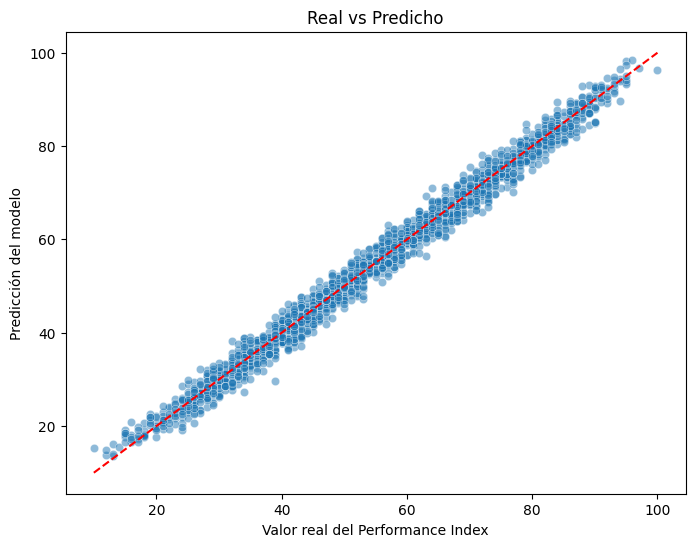

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Valor real del Performance Index")
plt.ylabel("Predicción del modelo")
plt.title("Real vs Predicho")
plt.plot([10, 100], [10, 100], 'r--')  # línea ideal
plt.show()

Los puntos están muy alineados con la diagonal, lo que indica que el modelo predice muy cerca del valor real en casi todos los casos.

No se observa curvatura ni inclinación sistemática: el modelo no sobrestima ni subestima consistentemente en ningún rango del índice.

Hay algo de dispersión alrededor de la línea ideal, pero es simétrica y reducida, lo que concuerda con los buenos valores de MAE y RMSE (~2 puntos).

## Conclusión

La distribución mixta del dataset (input uniforme, output natural) explica por qué la red neuronal logra un ajuste casi perfecto sin necesidad de regularización fuerte ni técnicas complejas.

El modelo tiene un alto poder predictivo, con errores bajos y comportamiento estable en todo el rango de Performance Index. Esta gráfica refuerza visualmente lo que ya mostraban las métricas: el modelo generaliza bien y es confiable.